In [49]:
import requests
import time, os
import pandas as pd
import numpy as np
import re
import patsy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()


import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV



from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Final Copy of EPL Players for All Seasons

In [6]:
# read clean version
df_21 = pd.read_csv("clean_20_21.csv")


# convert market_value to corresponding numbers

df_21['market_value']= df_21['market_value'].str.replace('Th.', 't')
df_21['market_value']

convert_value = {'m': 1000000, 't': 1000}
df_21.loc[:, 'market_value'] = pd.to_numeric(df_21['market_value'].str[:-1]) * \
                                            df_21['market_value'].str[-1].replace(convert_value)


# dummy variable for position
position_dummy = pd.get_dummies(df_21['player_pos'], drop_first=True)
position_dummy

# merge the dummy variable 
df_21 = pd.concat([df_21, position_dummy], axis=1)
df_21 = df_21.sort_values('Player', ascending=True)
df_21


<ipython-input-6-08dd997e9944>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_21['market_value']= df_21['market_value'].str.replace('Th.', 't')


,Player,player_appearance,market_value,player_pos,Goals,Assists,Passes,Passes per match,Yellow cards,Red cards,Fouls,Forward,Goalkeeper,Midfielder
116,Aaron Connolly,40,7000000.0,Forward,5,2,231,5.78,0,0,22,1,0,0
366,Aaron Mooy,96,8500000.0,Midfielder,9,6,4150,43.23,10,1,65,0,0,1
426,Aaron Ramsdale,72,12000000.0,Goalkeeper,0,1,1869,25.96,1,0,1,0,1,0
548,Aaron Wan-Bissaka,110,40000000.0,Defender,2,10,4723,42.94,16,1,75,0,0,0
147,Abdoulaye Doucouré,154,25000000.0,Midfielder,19,14,7862,51.05,36,0,163,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Yves Bissouma,83,17000000.0,Midfielder,2,0,2846,34.29,16,1,121,0,0,1
503,Zack Steffen,1,6000000.0,Goalkeeper,0,0,26,26.00,0,0,1,0,1,0
501,Çaglar Söyüncü,60,40000000.0,Defender,1,1,3758,62.63,7,1,54,0,0,0
349,Édouard Mendy,29,25000000.0,Goalkeeper,0,0,867,29.90,1,0,1,0,1,0


In [7]:
df_21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 116 to 389
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Player             586 non-null    object 
 1   player_appearance  586 non-null    int64  
 2   market_value       586 non-null    float64
 3   player_pos         586 non-null    object 
 4   Goals              586 non-null    int64  
 5   Assists            586 non-null    int64  
 6   Passes             586 non-null    int64  
 7   Passes per match   586 non-null    float64
 8   Yellow cards       586 non-null    int64  
 9   Red cards          586 non-null    int64  
 10  Fouls              586 non-null    int64  
 11  Forward            586 non-null    uint8  
 12  Goalkeeper         586 non-null    uint8  
 13  Midfielder         586 non-null    uint8  
dtypes: float64(2), int64(7), object(2), uint8(3)
memory usage: 56.7+ KB


In [8]:
df_21[['player_appearance', 'Goals', 'Assists', 'Passes', 'Yellow cards', 'Red cards', 'Fouls']] = df_21[['player_appearance', 'Goals', 'Assists', 'Passes', 'Yellow cards', 'Red cards', 'Fouls']].astype(float)

df_21

,Player,player_appearance,market_value,player_pos,Goals,Assists,Passes,Passes per match,Yellow cards,Red cards,Fouls,Forward,Goalkeeper,Midfielder
116,Aaron Connolly,40.0,7000000.0,Forward,5.0,2.0,231.0,5.78,0.0,0.0,22.0,1,0,0
366,Aaron Mooy,96.0,8500000.0,Midfielder,9.0,6.0,4150.0,43.23,10.0,1.0,65.0,0,0,1
426,Aaron Ramsdale,72.0,12000000.0,Goalkeeper,0.0,1.0,1869.0,25.96,1.0,0.0,1.0,0,1,0
548,Aaron Wan-Bissaka,110.0,40000000.0,Defender,2.0,10.0,4723.0,42.94,16.0,1.0,75.0,0,0,0
147,Abdoulaye Doucouré,154.0,25000000.0,Midfielder,19.0,14.0,7862.0,51.05,36.0,0.0,163.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Yves Bissouma,83.0,17000000.0,Midfielder,2.0,0.0,2846.0,34.29,16.0,1.0,121.0,0,0,1
503,Zack Steffen,1.0,6000000.0,Goalkeeper,0.0,0.0,26.0,26.00,0.0,0.0,1.0,0,1,0
501,Çaglar Söyüncü,60.0,40000000.0,Defender,1.0,1.0,3758.0,62.63,7.0,1.0,54.0,0,0,0
349,Édouard Mendy,29.0,25000000.0,Goalkeeper,0.0,0.0,867.0,29.90,1.0,0.0,1.0,0,1,0


In [9]:
cols = df_21.columns.tolist()
cols

cols = cols[2:3] + cols[0:2] + cols[3:]
df_21 = df_21[cols]
df_21

,market_value,Player,player_appearance,player_pos,Goals,Assists,Passes,Passes per match,Yellow cards,Red cards,Fouls,Forward,Goalkeeper,Midfielder
116,7000000.0,Aaron Connolly,40.0,Forward,5.0,2.0,231.0,5.78,0.0,0.0,22.0,1,0,0
366,8500000.0,Aaron Mooy,96.0,Midfielder,9.0,6.0,4150.0,43.23,10.0,1.0,65.0,0,0,1
426,12000000.0,Aaron Ramsdale,72.0,Goalkeeper,0.0,1.0,1869.0,25.96,1.0,0.0,1.0,0,1,0
548,40000000.0,Aaron Wan-Bissaka,110.0,Defender,2.0,10.0,4723.0,42.94,16.0,1.0,75.0,0,0,0
147,25000000.0,Abdoulaye Doucouré,154.0,Midfielder,19.0,14.0,7862.0,51.05,36.0,0.0,163.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,17000000.0,Yves Bissouma,83.0,Midfielder,2.0,0.0,2846.0,34.29,16.0,1.0,121.0,0,0,1
503,6000000.0,Zack Steffen,1.0,Goalkeeper,0.0,0.0,26.0,26.00,0.0,0.0,1.0,0,1,0
501,40000000.0,Çaglar Söyüncü,60.0,Defender,1.0,1.0,3758.0,62.63,7.0,1.0,54.0,0,0,0
349,25000000.0,Édouard Mendy,29.0,Goalkeeper,0.0,0.0,867.0,29.90,1.0,0.0,1.0,0,1,0


## Regression Modeling

In [10]:
features, target = ['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match',
                    'Yellow cards', 'Red cards', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder'], 'market_value'
X, y = df_21[features], df_21[target]

lm = LinearRegression() 
lm.fit(X, y)

LinearRegression()

In [11]:
lm.score(X,y) 

0.3173750828750699

In [12]:
corr_matrix = df_21.corr()
corr_matrix

,market_value,player_appearance,Goals,Assists,Passes,Passes per match,Yellow cards,Red cards,Fouls,Forward,Goalkeeper,Midfielder
market_value,1.000000,0.133868,0.366756,0.324198,0.178953,0.286131,0.060379,0.017028,0.143340,0.138159,-0.132917,0.029917
player_appearance,0.133868,1.000000,0.565221,0.682771,0.883562,0.247061,0.787731,0.517762,0.816997,-0.005737,-0.026156,-0.001158
Goals,0.366756,0.565221,1.000000,0.724467,0.381668,-0.015004,0.366096,0.291808,0.562315,0.382457,-0.158734,-0.040829
Assists,0.324198,0.682771,0.724467,1.000000,0.618987,0.153686,0.492540,0.289326,0.633857,0.143826,-0.180895,0.129521
Passes,0.178953,0.883562,0.381668,0.618987,1.000000,0.523931,0.822842,0.520085,0.782735,-0.189770,-0.090774,0.067011
Passes per match,0.286131,0.247061,-0.015004,0.153686,0.523931,1.000000,0.367833,0.198825,0.279324,-0.469591,-0.100244,0.023812
Yellow cards,0.060379,0.787731,0.366096,0.492540,0.822842,0.367833,1.000000,0.567569,0.887106,-0.130734,-0.202317,0.093341
Red cards,0.017028,0.517762,0.291808,0.289326,0.520085,0.198825,0.567569,1.000000,0.571626,-0.018842,-0.091904,-0.008732
Fouls,0.143340,0.816997,0.562315,0.633857,0.782735,0.279324,0.887106,0.571626,1.000000,0.046499,-0.270619,0.099254
Forward,0.138159,-0.005737,0.382457,0.143826,-0.189770,-0.469591,-0.130734,-0.018842,0.046499,1.000000,-0.177770,-0.397057


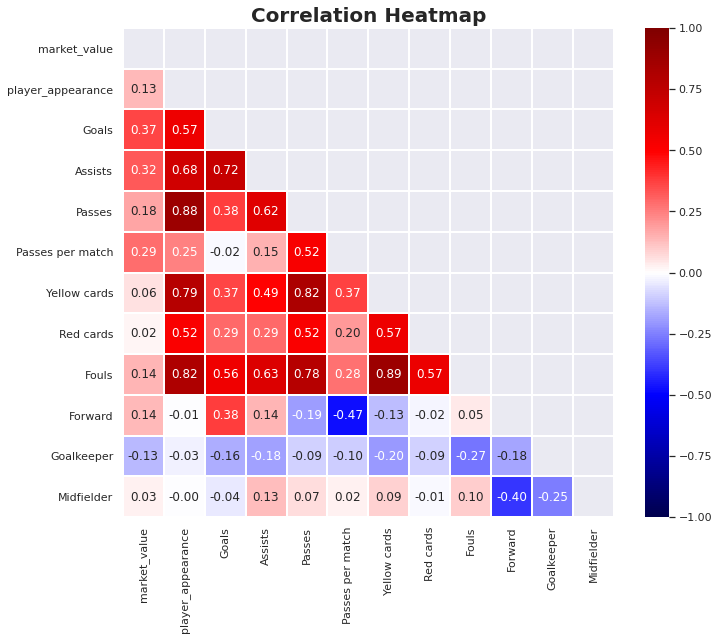

In [13]:
fig = plt.figure(figsize=[11,9])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap='seismic',linewidth=1,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=20);

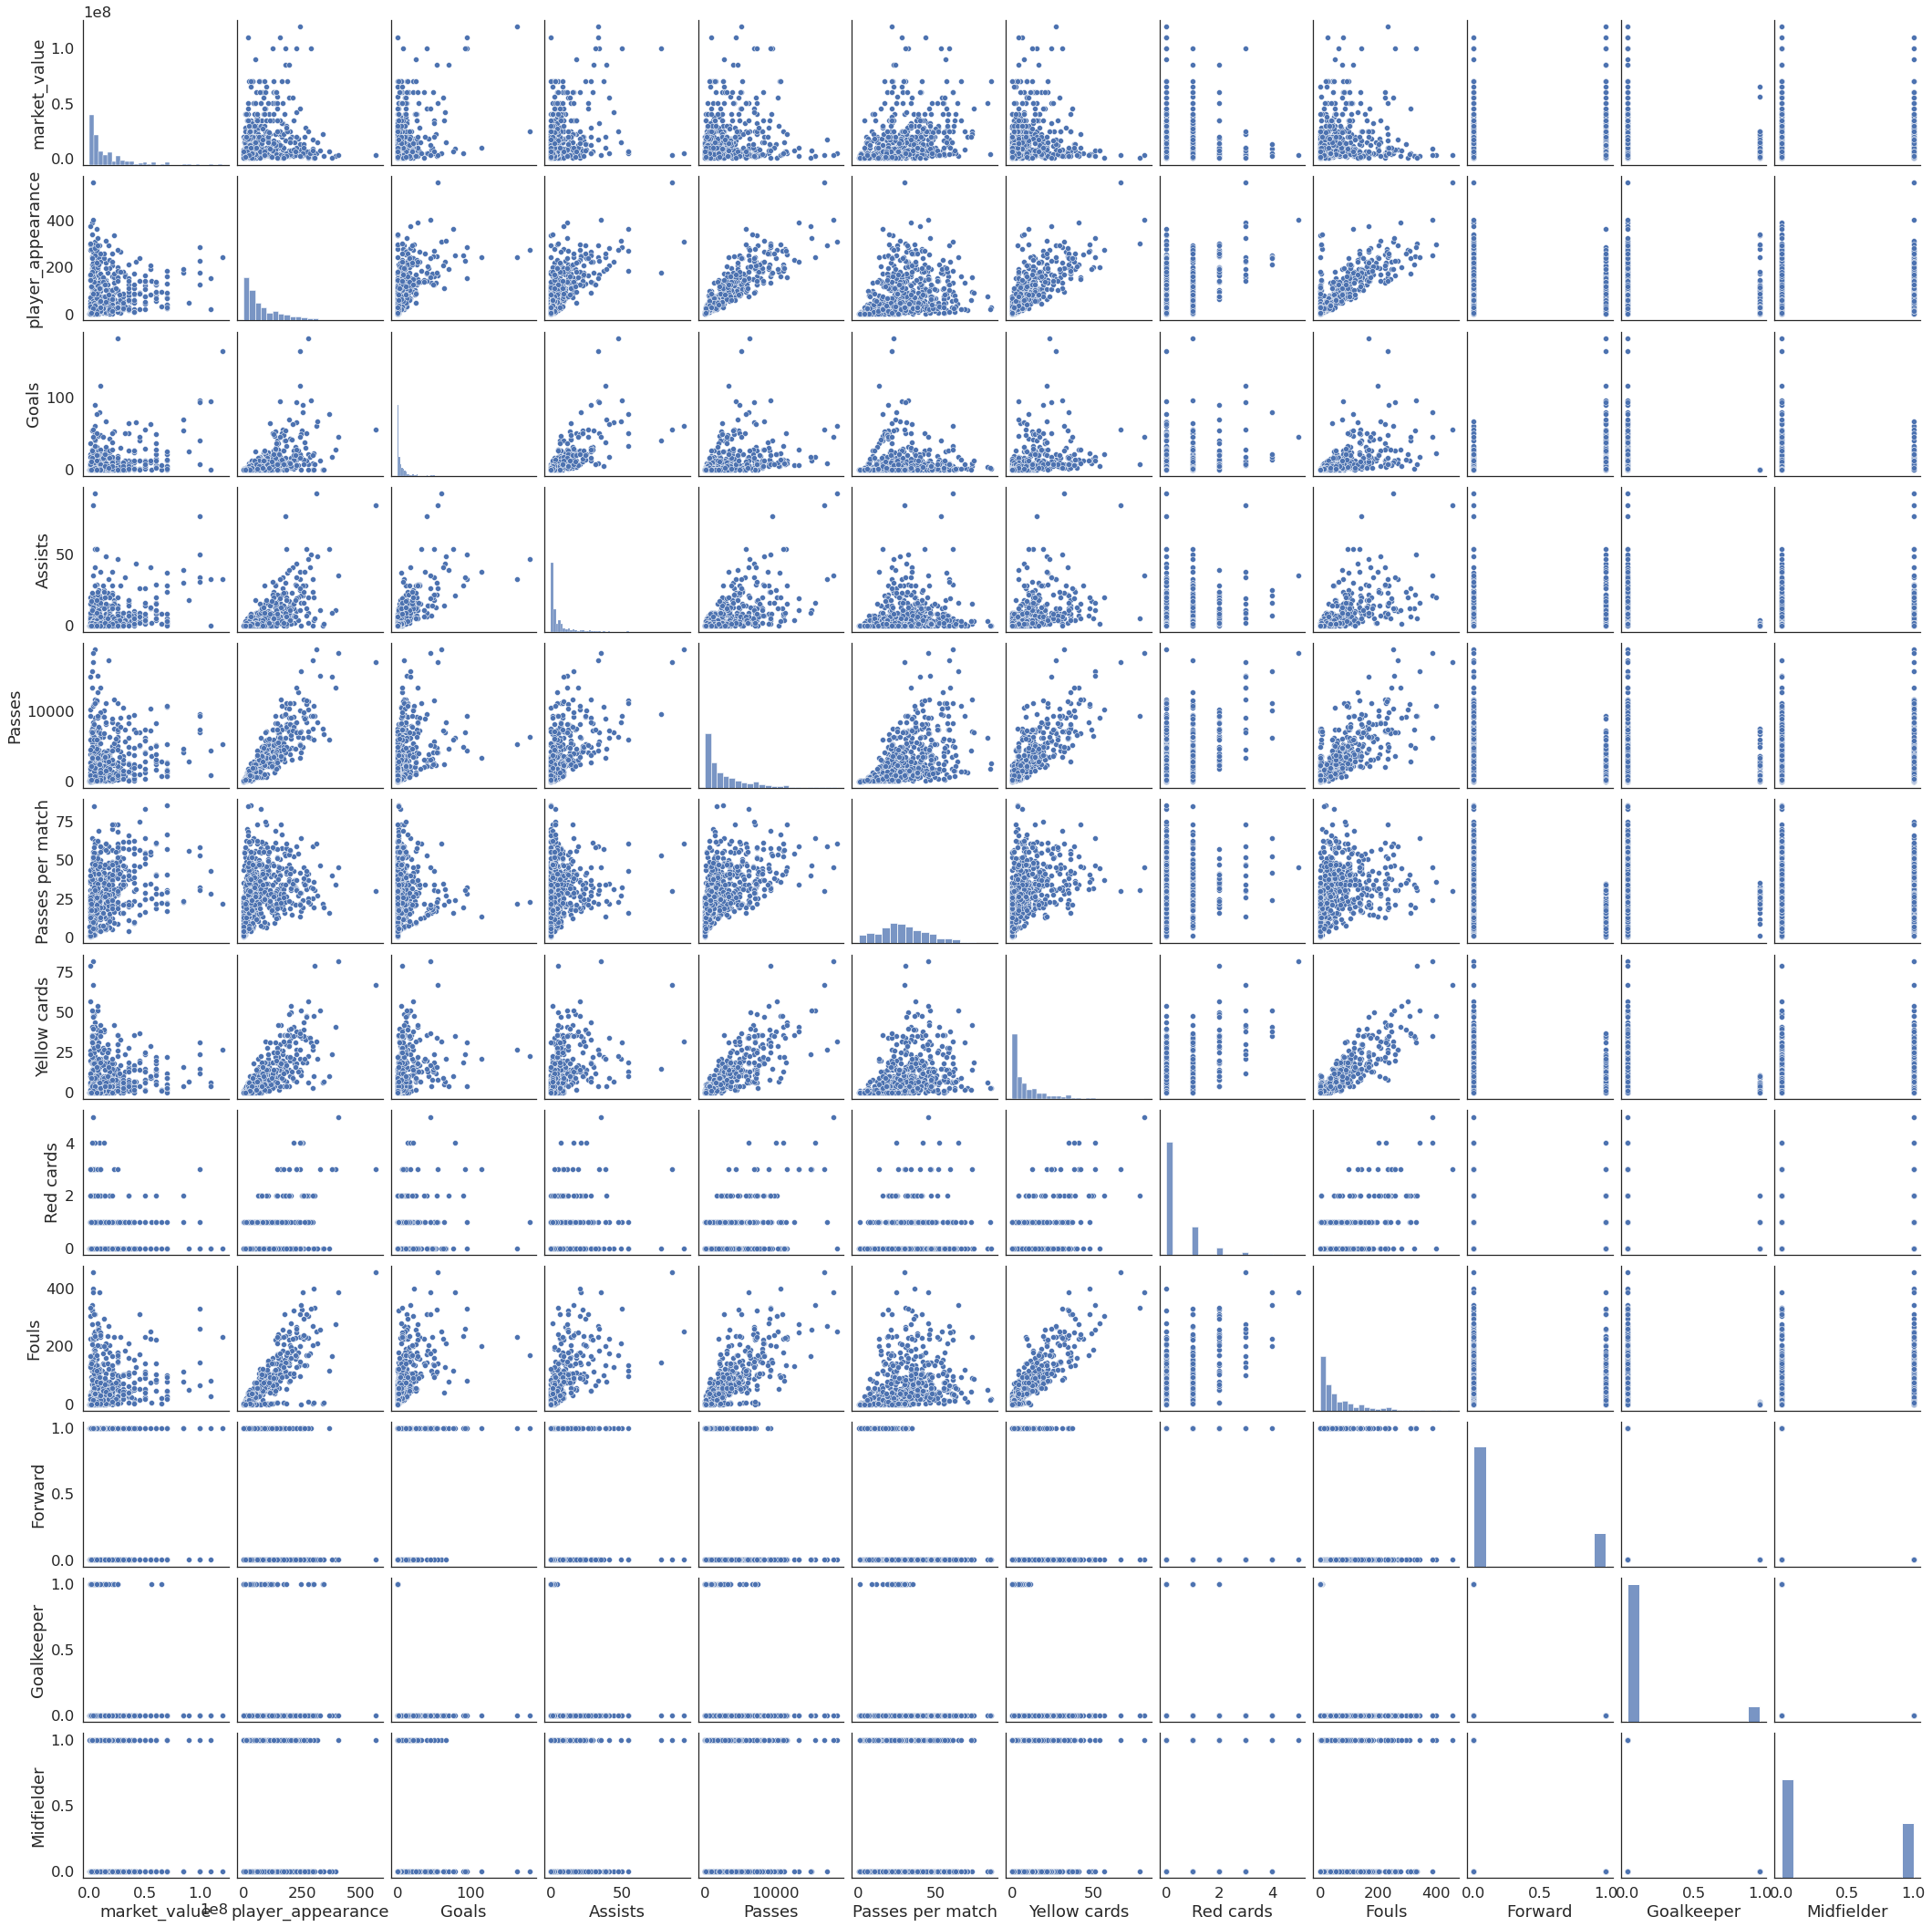

In [27]:
sns.set(style='white',font_scale=1.5)
sns.pairplot(df_21)
#plt.savefig('pairplot1.png',transparent=True, bbox_inches='tight')

### Drop Red Cards + Yellow cards

In [14]:
df_21_drop = df_21.drop(['Yellow cards', 'Red cards'], axis=1)
df_21_drop

,market_value,Player,player_appearance,player_pos,Goals,Assists,Passes,Passes per match,Fouls,Forward,Goalkeeper,Midfielder
116,7000000.0,Aaron Connolly,40.0,Forward,5.0,2.0,231.0,5.78,22.0,1,0,0
366,8500000.0,Aaron Mooy,96.0,Midfielder,9.0,6.0,4150.0,43.23,65.0,0,0,1
426,12000000.0,Aaron Ramsdale,72.0,Goalkeeper,0.0,1.0,1869.0,25.96,1.0,0,1,0
548,40000000.0,Aaron Wan-Bissaka,110.0,Defender,2.0,10.0,4723.0,42.94,75.0,0,0,0
147,25000000.0,Abdoulaye Doucouré,154.0,Midfielder,19.0,14.0,7862.0,51.05,163.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
71,17000000.0,Yves Bissouma,83.0,Midfielder,2.0,0.0,2846.0,34.29,121.0,0,0,1
503,6000000.0,Zack Steffen,1.0,Goalkeeper,0.0,0.0,26.0,26.00,1.0,0,1,0
501,40000000.0,Çaglar Söyüncü,60.0,Defender,1.0,1.0,3758.0,62.63,54.0,0,0,0
349,25000000.0,Édouard Mendy,29.0,Goalkeeper,0.0,0.0,867.0,29.90,1.0,0,1,0


Text(0.5, 1.0, 'Correlation Heatmap')

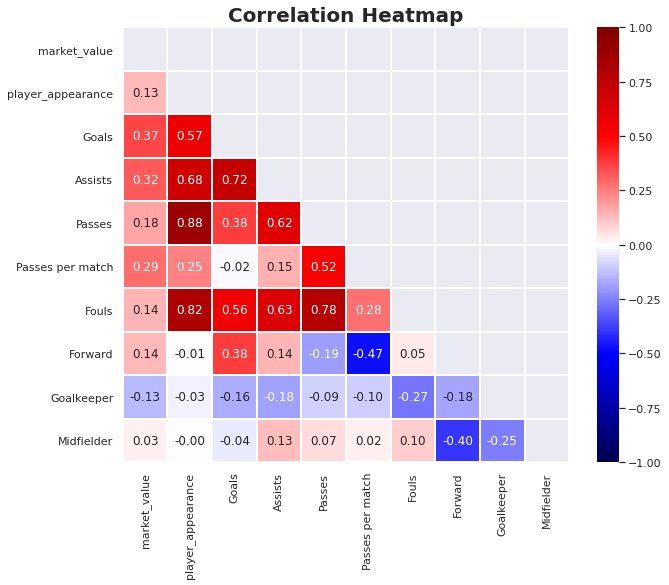

In [15]:
#corelation map after removing 2 features

corr_matrix = df_21_drop.corr()
fig = plt.figure(figsize=[10,8])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap='seismic',linewidth=1,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=20)

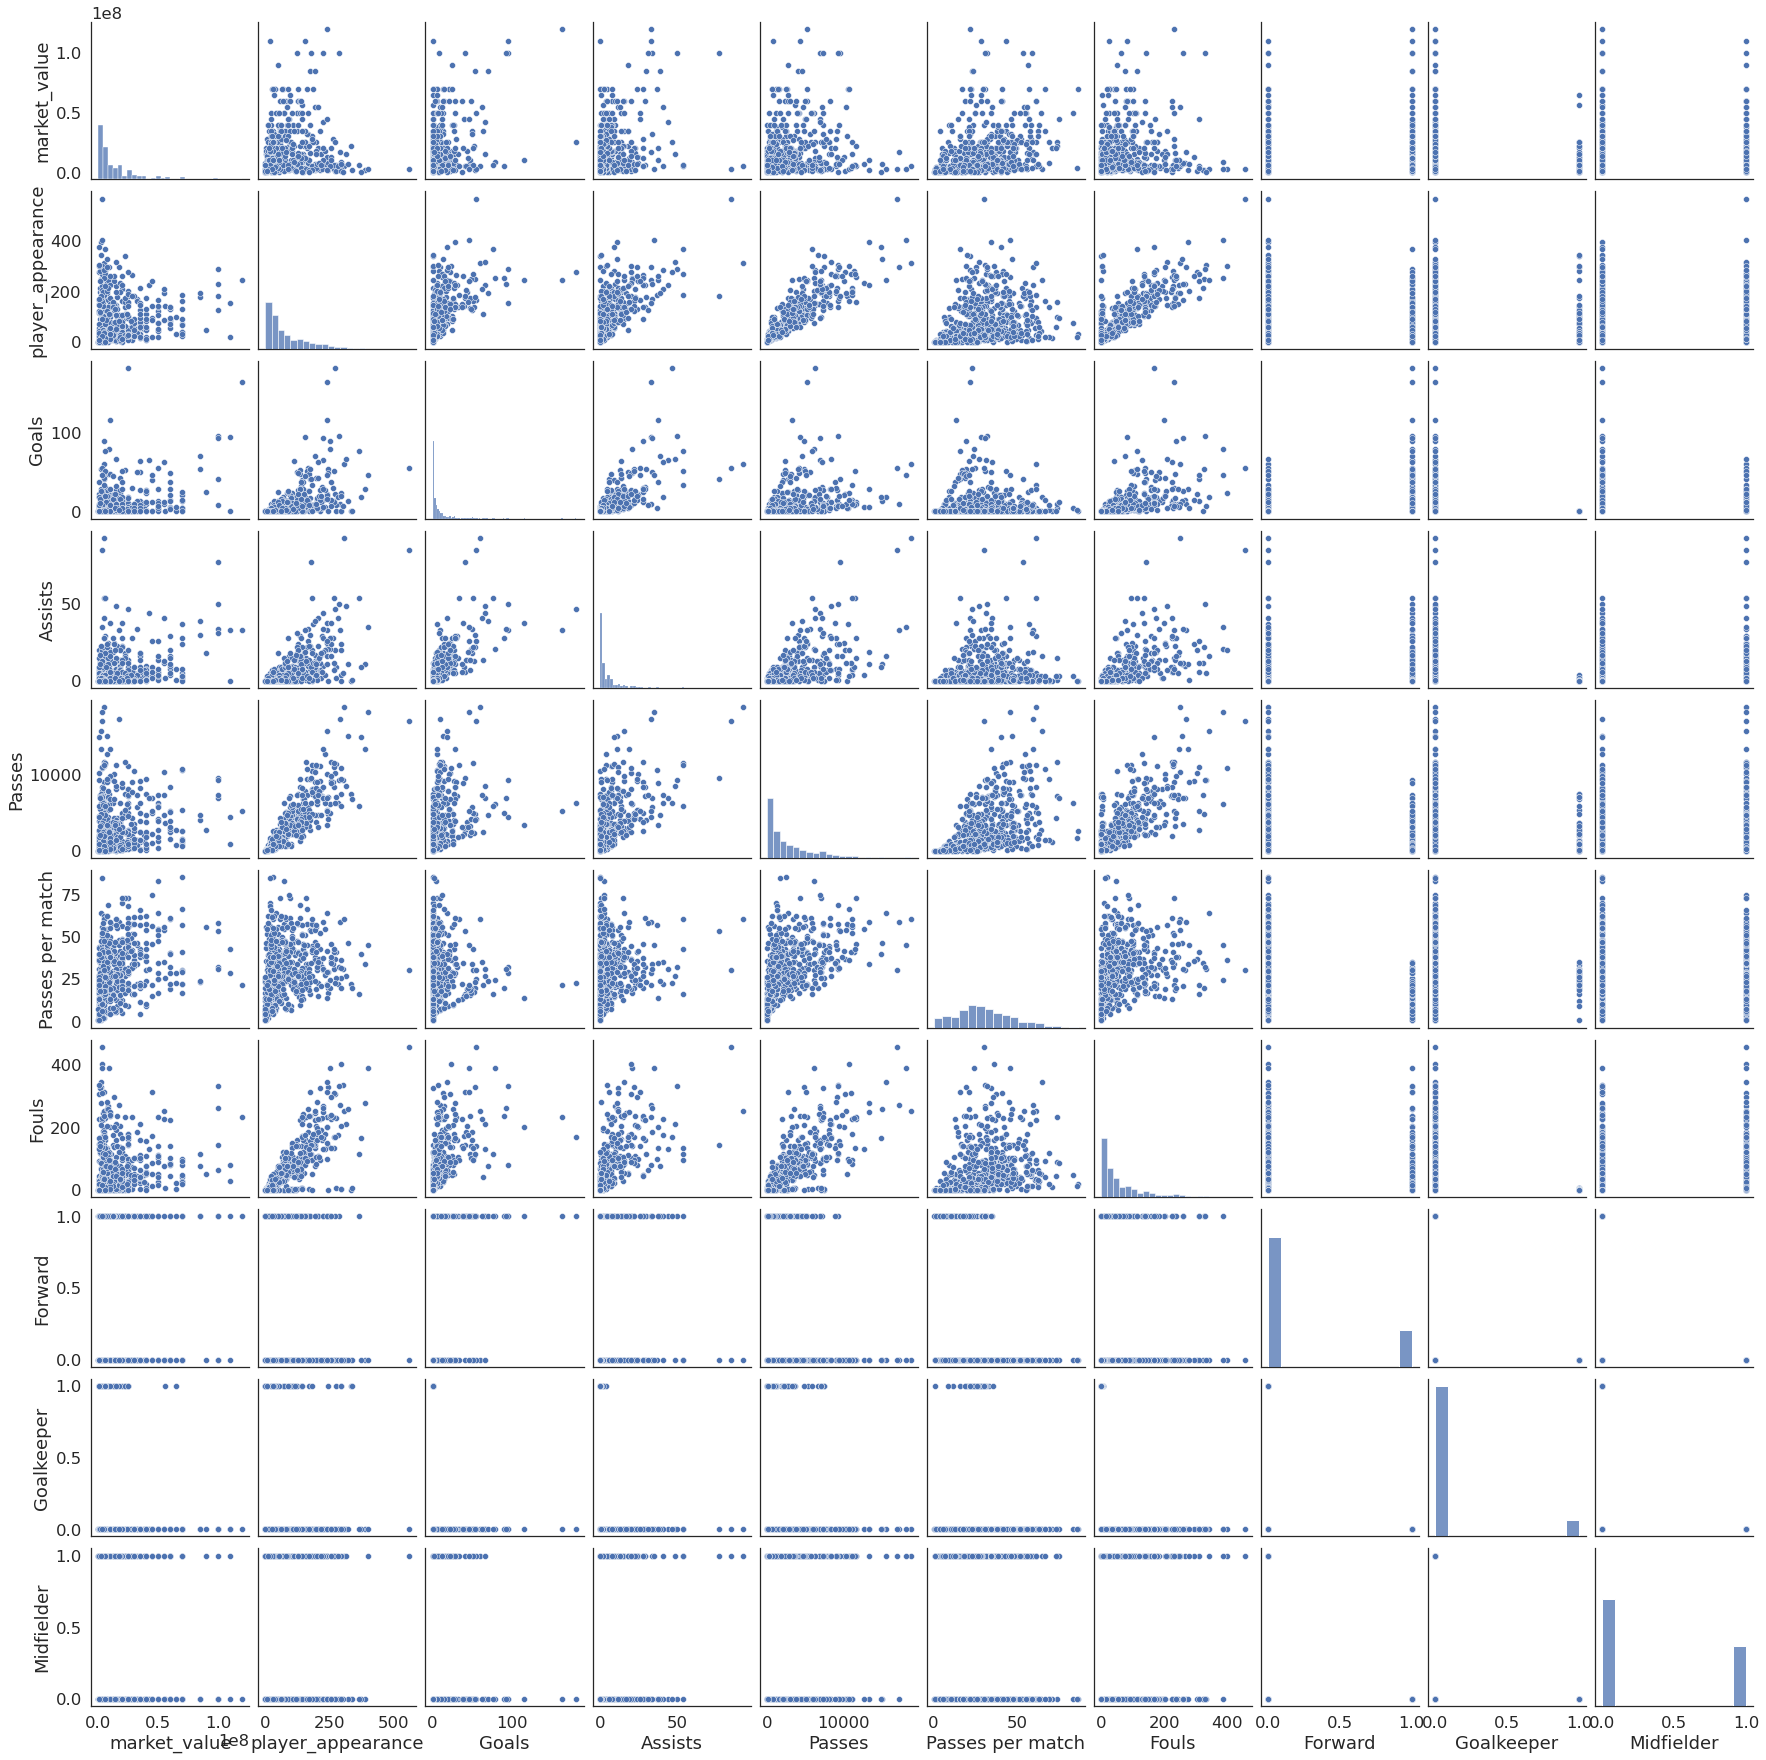

In [152]:
sns.set(style='white',font_scale=1.5)
sns.pairplot(df_21_drop)
plt.savefig('pairplot1.png',transparent=True, bbox_inches='tight');

In [18]:
y, X = patsy.dmatrices("Q('market_value') ~ player_appearance + Goals + Assists + Passes + Q('Passes per match') + Fouls + Forward + Goalkeeper + Midfielder", data=df_21_drop, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q('market_value')   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     29.19
Date:                Thu, 13 May 2021   Prob (F-statistic):           6.26e-42
Time:                        14:05:56   Log-Likelihood:                -10550.
No. Observations:                 586   AIC:                         2.112e+04
Df Residuals:                     576   BIC:                         2.116e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -5.827e+06   2.65e+06     -2.195      0.029    -1.1e+07   -6.14e+05
player_appearance     -3.608e+04   2.46e+04     -1.464      0.144   -8.45e+04    1.23e+04
Goals                  3.842e+05   6.45e+04      5.956      0.000    2.58e+05    5.11e+05
Assists                2.482e+05   1.09e+05      2.278      0.023    3.42e+04    4.62e+05
Passes                  454.7049    650.566      0.699      0.485    -823.065    1732.475
Q('Passes per match')  5.574e+05   6.52e+04      8.556      0.000    4.29e+05    6.85e+05
Fouls                 -5.768e+04   1.72e+04     -3.350      0.001   -9.15e+04   -2.39e+04
Forward                1.352e+07   2.49e+06      5.424      0.000    8.62e+06    1.84e+07
Goalkeeper             1.741e+06   2.67e+06      0.651      0.515   -3.51e+06    6.99e+06
Midfielder             6.247e+06   1.78e+06      3.511      0.000    2.75e+06    9.74e+06
==============================================================================
Omnibus:                      158.155   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              562.523
Skew:                           1.225   Prob(JB):                    7.07e-123
Kurtosis:                       7.128   Cond. No.                     2.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
# make copy with log market value
df_21_drop_copy = df_21_drop.copy()

In [41]:

df_21_drop_copy['market_value'] = np.log(df_21_drop_copy['market_value'])
df_21_drop_copy = df_21_drop_copy.rename(columns={'market_value':'Log market_value'}) # log market_values

df_21_drop_copy



,Log market_value,Player,player_appearance,player_pos,Goals,Assists,Passes,Passes per match,Fouls,Forward,Goalkeeper,Midfielder
116,15.761421,Aaron Connolly,40.0,Forward,5.0,2.0,231.0,5.78,22.0,1,0,0
366,15.955577,Aaron Mooy,96.0,Midfielder,9.0,6.0,4150.0,43.23,65.0,0,0,1
426,16.300417,Aaron Ramsdale,72.0,Goalkeeper,0.0,1.0,1869.0,25.96,1.0,0,1,0
548,17.504390,Aaron Wan-Bissaka,110.0,Defender,2.0,10.0,4723.0,42.94,75.0,0,0,0
147,17.034386,Abdoulaye Doucouré,154.0,Midfielder,19.0,14.0,7862.0,51.05,163.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
71,16.648724,Yves Bissouma,83.0,Midfielder,2.0,0.0,2846.0,34.29,121.0,0,0,1
503,15.607270,Zack Steffen,1.0,Goalkeeper,0.0,0.0,26.0,26.00,1.0,0,1,0
501,17.504390,Çaglar Söyüncü,60.0,Defender,1.0,1.0,3758.0,62.63,54.0,0,0,0
349,17.034386,Édouard Mendy,29.0,Goalkeeper,0.0,0.0,867.0,29.90,1.0,0,1,0


Text(0.5, 1.0, 'Correlation Heatmap')

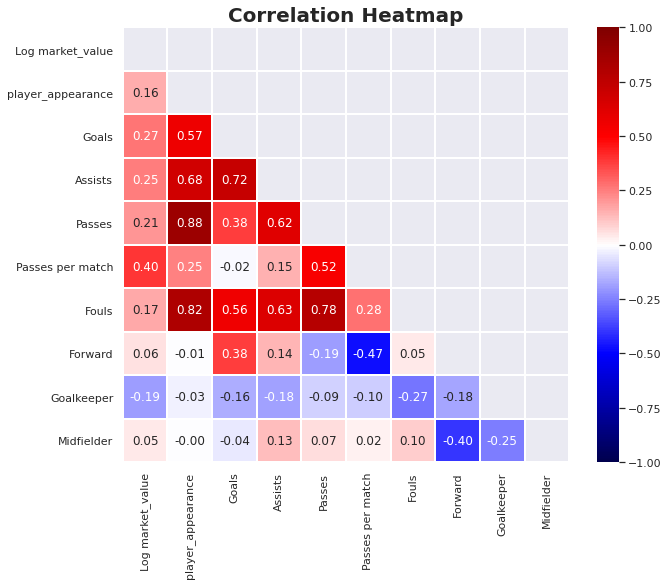

In [42]:
corr_matrix = df_21_drop_copy.corr()
fig = plt.figure(figsize=[10,8])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,cmap='seismic',linewidth=1,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=20)

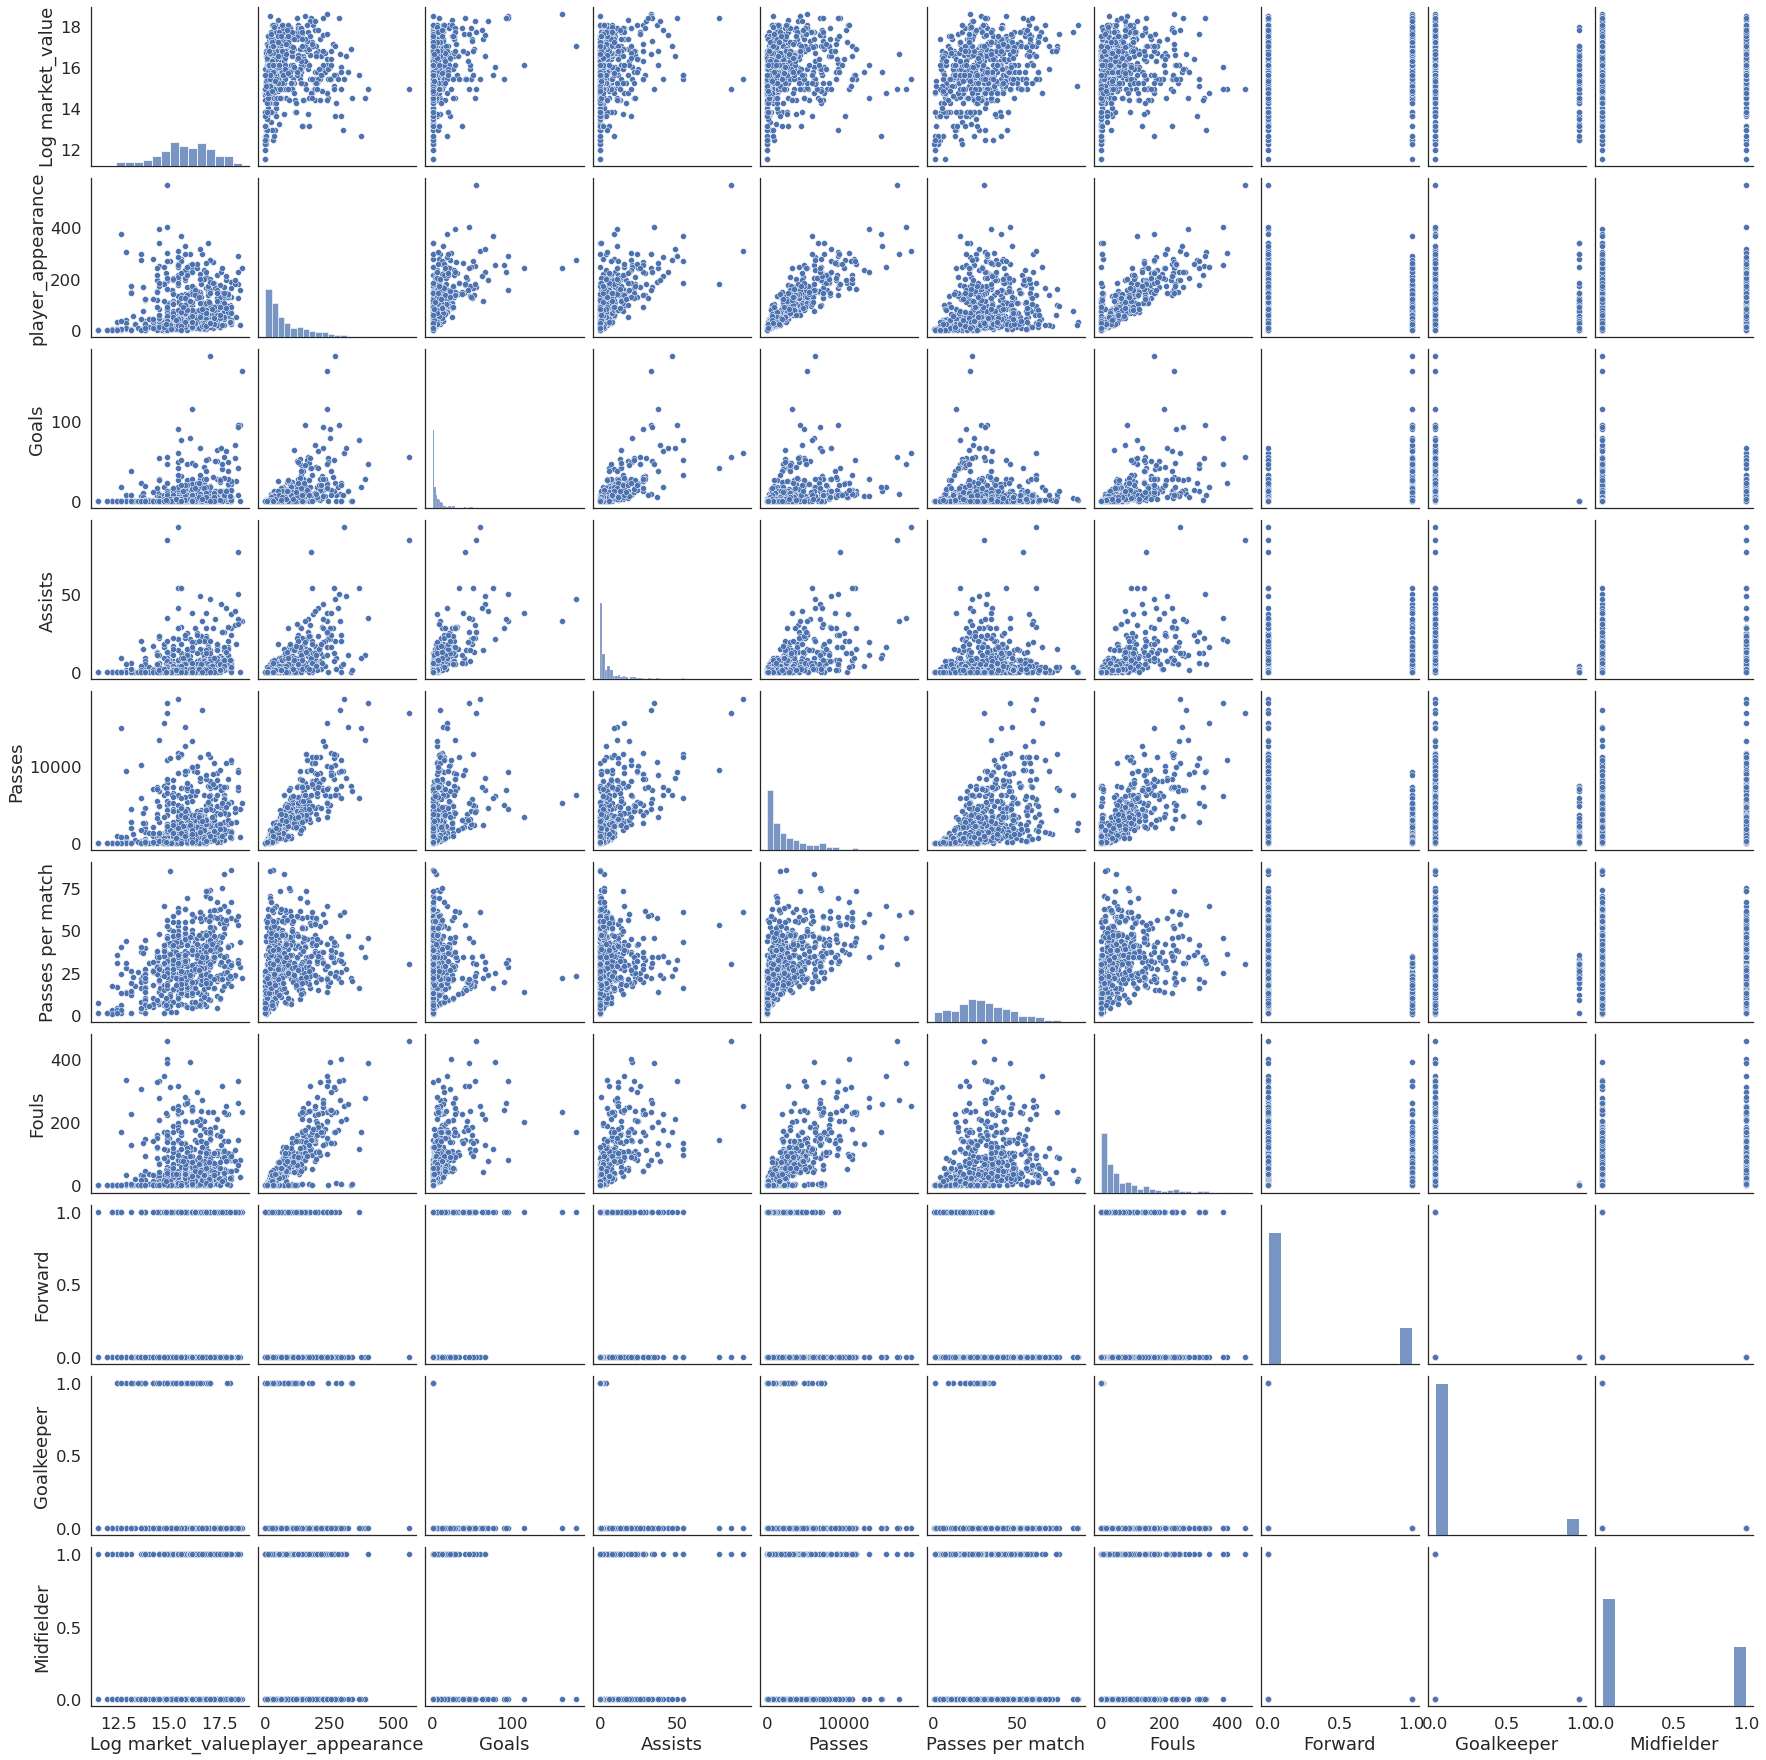

In [51]:
sns.set(style='white',font_scale=1.5)
sns.pairplot(df_21_drop_copy)

In [43]:
y, X = patsy.dmatrices("Q('Log market_value') ~ player_appearance + Goals + Assists + Passes + Q('Passes per match') + Fouls + Forward + Goalkeeper + Midfielder", data=df_21_drop_copy, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Q('Log market_value')   R-squared:                       0.319
Model:                               OLS   Adj. R-squared:                  0.308
Method:                    Least Squares   F-statistic:                     29.94
Date:                   Thu, 13 May 2021   Prob (F-statistic):           6.78e-43
Time:                           14:22:58   Log-Likelihood:                -911.80
No. Observations:                    586   AIC:                             1844.
Df Residuals:                        576   BIC:                             1887.
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                13.7081      0.191     71.796      0.000      13.333      14.083
player_appearance         0.0052      0.002      2.913      0.004       0.002       0.009
Goals                     0.0131      0.005      2.824      0.005       0.004       0.022
Assists                   0.0086      0.008      1.101      0.271      -0.007       0.024
Passes                   -0.0001   4.68e-05     -2.925      0.004      -0.000    -4.5e-05
Q('Passes per match')     0.0582      0.005     12.416      0.000       0.049       0.067
Fouls                    -0.0038      0.001     -3.069      0.002      -0.006      -0.001
Forward                   1.0630      0.179      5.930      0.000       0.711       1.415
Goalkeeper               -0.2679      0.192     -1.393      0.164      -0.646       0.110
Midfielder                0.5265      0.128      4.114      0.000       0.275       0.778
==============================================================================
Omnibus:                       16.682   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.685
Skew:                          -0.424   Prob(JB):                     0.000144
Kurtosis:                       2.935   Cond. No.                     2.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing different models

In [182]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [183]:
#Train:80 test:20

#Create train/test/validation set

X = df_21_drop_copy.loc[:,['player_appearance','Goals','Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']]
y = df_21_drop_copy['Log market_value']

# perform train/val split

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [184]:
# Cross Validation on Linear Regression - Training Data

kf = KFold(n_splits=5, shuffle=True, random_state = 32)


#regular cross validation 
lm_cv = LinearRegression()

#fit model
lm_cv.fit(X, y)

#all five values
print(cross_val_score(lm_cv, X, y, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(lm_cv, X, y, cv=kf, scoring='r2')))

[0.27184901 0.42101516 0.26598496 0.30401606 0.20568055]
0.29370915015333454


In [185]:
# Standard Scaling process for Cross Validation Ridge + Lasso

std = StandardScaler()
std.fit(X.values)

X_scaled = std.transform(X.values)
X_test_scaled = std.transform(X_test.values)

In [186]:
#determine best alpha
rm_cv = RidgeCV(alphas=[0.1, 1.0,10.0])

new_ridge=rm_cv.fit(X_scaled, y)
best_alpha = new_ridge.alpha_

print(best_alpha)

1.0


In [187]:
#Ridge CV Regression
kf = KFold(n_splits=5, shuffle=True, random_state = 32)
RidgeCV = Ridge(alpha=0.1)

#fit model
RidgeCV.fit(X_scaled, y)

#results from ridge reg cross val
#all five values
print(cross_val_score(RidgeCV, X_scaled, y, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(RidgeCV, X_scaled, y, cv=kf, scoring='r2')))

[0.27169959 0.42087798 0.26603203 0.30425687 0.20601552]
0.2937763946621092


In [188]:
#determine best alpha
ls_cv = LassoCV(alphas=[0.1, 1.0, 10.0])

new_lasso=ls_cv.fit(X_scaled, y)
best_alpha = new_lasso.alpha_

print(best_alpha)

0.1


In [189]:
#Lasso CV Regresion 
kf = KFold(n_splits=5, shuffle=True, random_state = 32)
LassoCV = Lasso(alpha=0.1)

#fit model
LassoCV.fit(X_scaled, y)

#results from ridge reg cross val
#all five values
print(cross_val_score(LassoCV, X_scaled, y, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(LassoCV, X_scaled, y, cv=kf, scoring='r2')))

[0.20763336 0.32239865 0.23523811 0.20972506 0.2206841 ]
0.23913585876762494


In [192]:
# run test for RidgeCV because it has the highest r-squared value above among 3 models

test_prediction = RidgeCV.predict(X_test_scaled)

In [193]:
r2_score(y_test, test_prediction)

0.2349766995548047

In [181]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

y_err=mae(y_test, test_prediction)
print(y_err)

0.9297204848158058


Text(0.5, 1.0, 'Logged Market Value of English Premier League Players (euros)')

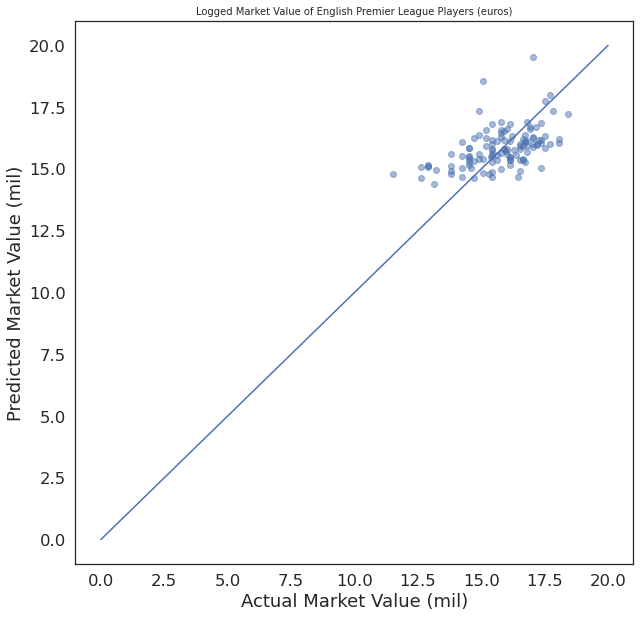

In [198]:
plt.figure(figsize = (10,10))
plt.scatter(y_test, test_prediction, alpha=.5)
plt.plot(np.linspace(0,20,10), np.linspace(0,20,10))
plt.xlabel("Actual Market Value (mil)")
plt.ylabel("Predicted Market Value (mil)")
plt.title("Logged Market Value of English Premier League Players (euros)", fontsize=10)

#plt.savefig('Actual vs. Predicted.png');

## Trying different modeling 

In [199]:
# different modeling for linear regression

import random
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
df_21_drop_train, df_21_drop_val = train_test_split(df_21_drop, test_size=0.25, random_state=3)

In [202]:
# train and validate simple model
m = LinearRegression()
m.fit(df_21_drop_train[['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']],df_21_drop_train['market_value'])
m.score(df_21_drop_train[['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']],df_21_drop_train['market_value'])

0.29777558918150837

In [203]:
m.score(df_21_drop_val[['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']],df_21_drop_val['market_value'])

0.36216134806209554

In [241]:
# seems to be underfitting so let's try to make it more complicated  polynomial
# passes per match shows curved relationship with market value

# seperate features from target
X = df_21_drop.loc[:, ['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']]
y = df_21_drop['market_value']

In [242]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

In [243]:
split_and_validate(X, y)


Validation R^2 score was: 0.31899051258041744
Feature coefficient results: 

player_appearance : -24107.68
Goals : 455964.05
Assists : -70799.46
Passes : 514.06
Passes per match : 545606.65
Fouls : -55337.89
Forward : 12837766.39
Goalkeeper : 1285969.28
Midfielder : 6733589.01


In [244]:
X2 = X.copy()

X2['OQ2'] = X2['Passes per match'] ** 2
X2['GLA2'] = X2['Assists'] ** 2

split_and_validate(X2, y)


Validation R^2 score was: 0.3410087800365501
Feature coefficient results: 

player_appearance : -58624.82
Goals : 426614.48
Assists : 622729.15
Passes : 1340.39
Passes per match : 760211.20
Fouls : -72196.18
Forward : 12840058.94
Goalkeeper : 1851622.20
Midfielder : 6078573.33
OQ2 : -3771.15
GLA2 : -10733.95


In [266]:

# Split into train, val, and test


X, X_test, y, y_test = train_test_split(df_21_drop[['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']], 
                                        df_21_drop['market_value'], test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [267]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.38154399945207595

In [268]:
# Score on validation set
lr.score(X_val,y_val)

0.16913109066766052

In [269]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

-0.06640317837755405

In [270]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

-1.6745881385256665

In [271]:
lr_poly.coef_

array([-3.95867812e+13, -3.92935364e+05,  2.19010485e+06, -6.58580200e+05,
        4.24615221e+06,  4.37046951e+05, -1.50413664e+05, -3.81088012e+06,
       -2.75416419e+06, -3.01112147e+06,  1.74887049e+03,  6.54368595e+02,
        4.51509454e+03, -1.45887998e+02, -4.21799851e+06, -1.07825366e+03,
       -1.92680503e+04,  4.83801193e+03, -1.67009663e+05,  2.53504794e+04,
       -1.92546010e+05,  4.50169484e+02, -1.84206209e+04, -1.06771905e+04,
       -2.24446594e+05,  2.26384953e-04,  4.03595243e+05,  1.61858668e+05,
       -1.22838109e+03,  4.80024002e+04,  3.02029036e+04,  1.73554423e+06,
        4.14016246e+06, -1.27021495e+06,  2.40797991e+00, -4.55868152e+02,
        1.81141335e+01,  3.47629404e+03,  4.53991862e+03,  1.60939713e+04,
        1.75573082e+02,  1.26611376e+03,  6.00920914e+05, -1.83096512e+05,
       -3.85563626e+05,  5.95496066e+02, -1.84960079e+05, -5.27756663e+05,
       -3.78786569e+05, -3.81088012e+06,  0.00000000e+00,  0.00000000e+00,
       -2.75416415e+06,  

In [272]:
from sklearn.linear_model import LassoCV, RidgeCV


# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Apply the same scaler to val set
X_val_poly_scaled = scaler.transform(X_val_poly)

# Fit a LASSO model using polynomial features
lasso = LassoCV()
lasso.fit(X_train_poly_scaled,y_train)
lasso.score(X_train_poly_scaled,y_train)

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10966310697208.0, tolerance: 10582010271428.572
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10607721888384.0, tolerance: 10582010271428.572
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11620759459912.0, tolerance: 10582010271428.572
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

0.4072141785291187

In [273]:
# Score on validation set
lasso.score(X_val_poly_scaled, y_val)

0.23513609436774974

In [274]:

list(zip(poly.get_feature_names(['player_appearance','Goals', 'Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']),lasso.coef_))

[('1', 0.0),
 ('player_appearance', -0.0),
 ('Goals', 0.0),
 ('Assists', 0.0),
 ('Passes', -0.0),
 ('Passes per match', 4106577.411010813),
 ('Fouls', -0.0),
 ('Forward', 0.0),
 ('Goalkeeper', 0.0),
 ('Midfielder', 0.0),
 ('player_appearance^2', -0.0),
 ('player_appearance Goals', -0.0),
 ('player_appearance Assists', -0.0),
 ('player_appearance Passes', -0.0),
 ('player_appearance Passes per match', -0.0),
 ('player_appearance Fouls', -4310148.236607902),
 ('player_appearance Forward', 0.0),
 ('player_appearance Goalkeeper', 0.0),
 ('player_appearance Midfielder', -0.0),
 ('Goals^2', 0.0),
 ('Goals Assists', 0.0),
 ('Goals Passes', -0.0),
 ('Goals Passes per match', 6176266.840656232),
 ('Goals Fouls', -0.0),
 ('Goals Forward', 0.0),
 ('Goals Goalkeeper', 0.0),
 ('Goals Midfielder', 0.0),
 ('Assists^2', 0.0),
 ('Assists Passes', -0.0),
 ('Assists Passes per match', 1225613.161194972),
 ('Assists Fouls', 0.0),
 ('Assists Forward', 1239406.3501307578),
 ('Assists Goalkeeper', 0.0),
 ('A

In [265]:
# Fit a LASSO model on full dataset using scaled, polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

lasso = LassoCV()
lasso.fit(X_poly_scaled,y)

# Apply the same polynomial and scaling transformations to test set, then score
X_test_poly = poly.transform(X_test)
X_test_poly_scaled = scaler.transform(X_test_poly)

lasso.score(X_test_poly_scaled, y_test)

/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24123228961472.0, tolerance: 13338036233288.77
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13576401061448.0, tolerance: 13338036233288.77
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18278563244416.0, tolerance: 13338036233288.77
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desce

0.09666617929631371

## Different approach to modeling 3

-----------------------------------------------------------------------------

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [214]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(pred,y,alpha=0.1)
    plt.plot(y, y, color='red',linewidth=1,)
    plt.title("Regression fit")
    plt.xlabel("Predicted y")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res,alpha=0.1)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt,)
    plt.title("Normal Q-Q plot")

In [215]:
y = df_21_drop_copy['Log market_value']
X = df_21_drop_copy.drop(['Player','Log market_value', 'player_pos'],axis=1)

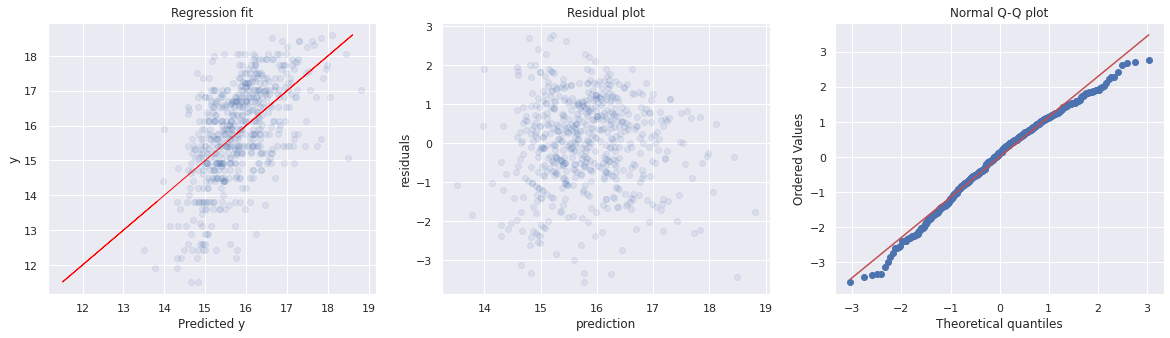

In [216]:
import scipy.stats as stats

sns.set(style='darkgrid')
diagnostic_plot(X, y)

In [217]:
# divide train/val/test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [218]:
selected_columns = ['player_appearance','Goals','Assists', 'Passes', 'Passes per match', 'Fouls', 'Forward', 'Goalkeeper', 'Midfielder']

In [219]:
# explore Lasso
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(X_train_val[selected_columns], y_train_val)
list(zip(selected_columns, lasso_model.coef_))

[('player_appearance', 0.001990837521764642),
 ('Goals', 0.021447056514190405),
 ('Assists', 0.005189708453054009),
 ('Passes', -0.00011691199257602695),
 ('Passes per match', 0.04487939035042483),
 ('Fouls', -0.000836739447017721),
 ('Forward', 0.0),
 ('Goalkeeper', -0.0),
 ('Midfielder', 0.0)]

In [220]:
std = StandardScaler()
std.fit(X_train_val.values)
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [221]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [222]:
# finding alpha value that gives lowest MAE for Lasso CV

alphavec = 10**np.linspace(-15,4,400)
lasso_model = LassoCV(alphas = alphavec, cv=kf)
lasso_model.fit(X_tr, y_train_val)
lasso_model.alpha_


/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18120257511139926, tolerance: 0.07087605383477015
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21970762508465214, tolerance: 0.07087605383477015
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4533051845484124, tolerance: 0.07087605383477015
  model = cd_fast.enet_coordinate_descent_gram(
/home/munwon/ENTER/lib/python3.8/site-packages/sklearn/linear_model/_co

0.0026826957952797163

In [223]:
# finding alpha value that gives lowest MAE for Ridge CV

alphavec = 10**np.linspace(-2,2,200)
ridge_model = RidgeCV(alphas = alphavec, cv=kf)
ridge_model.fit(X_tr, y_train_val)
ridge_model.alpha_


5.17092024289676

In [224]:
list(zip(X_train_val.columns, ridge_model.coef_))

[('player_appearance', 0.36707444073910434),
 ('Goals', 0.2984523267091576),
 ('Assists', -0.007147086451779529),
 ('Passes', -0.35205969728218733),
 ('Passes per match', 0.8850171817679581),
 ('Fouls', -0.2585682378974188),
 ('Forward', 0.3924078399312825),
 ('Goalkeeper', -0.10323611719903034),
 ('Midfielder', 0.22216388975573698)]

In [225]:
ridge_model_final = Ridge(alpha = 0.9329304026284686) 
Mean_R2_Ridge_CV = np.mean(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='r2'))
Mean_R2_Ridge_CV

0.28292934939224434

In [226]:

Std_R2_Ridge_CV = np.std(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='r2'))
Std_R2_Ridge_CV

0.10348683771180166

In [227]:
Mean_MAE_Ridge_CV = -np.mean(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Mean_MAE_Ridge_CV

0.9207495845216915

In [228]:

Std_MAE_Ridge_CV = np.std(cross_val_score(ridge_model_final, X_tr, y_train_val, cv=kf, scoring='neg_mean_absolute_error'))
Std_MAE_Ridge_CV

0.0719636769784245

In [230]:

Test_Set = pd.DataFrame(y_test).join(X_test).join(pd.DataFrame(df_21_drop['Player']))
Test_Set['Log Market Value'] = np.exp(Test_Set['Log market_value'] )
Test_Set = Test_Set.rename(columns={'Log market_value':'Market Value'})
Test_Set['Predicted Market Value'] = np.exp(predicted)
Test_Set = Test_Set.sort_values(by='Predicted Market Value',ascending=False)
#Test_Set['Market Value'] = Test_Set['Market Value'].apply(lambda x : "{:,}".format(int(x)))
#Test_Set['Predicted Market Value'] = Test_Set['Predicted Market Value'].apply(lambda x : "{:,}".format(int(x)))
Test_Set = Test_Set[['Player','Market Value','Predicted Market Value','Goals','Assists','Passes','Passes per match','Fouls','Forward', 'Goalkeeper', 'Midfielder']]
Test_Set.reset_index(inplace=True)
Test_Set.drop('index',axis=1,inplace=True)
Test_Set

NameError: name 'predicted' is not defined